In [1]:
import matplotlib.pyplot as plt                      
import seaborn as sns         
import pandas as pd  
import numpy as np 
np.random.seed(0)

# 1.Подготовка данных

### Данные о покупках пользователей:

In [2]:
users_data = pd.read_csv('../input/sbermarket-competition/train.csv')
users_data.head()

users_data['target'] = 0
users_data['count'] = 1
users_data = users_data.drop(['order_completed_at'], axis = 1)
users_data.head()

,user_id,cart,target,count
0,2,399,0,1
1,2,14,0,1
2,2,198,0,1
3,2,88,0,1
4,2,157,0,1


### Пример решения:

In [3]:
sample_data = pd.read_csv('../input/sbermarket-competition/sample_submission.csv')
sample_data.head()

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


In [4]:
sample_data[['user_id', 'cart']] = sample_data['id'].str.split(';', expand = True)
sample_data['user_id'] = sample_data['user_id'].astype('int64')
sample_data.head()

,id,target,user_id,cart
0,0;133,0,0,133
1,0;5,1,0,5
2,0;10,0,0,10
3,0;396,1,0,396
4,0;14,0,0,14


###  Если юзер купил товар < 2 раз, то target = 0

In [5]:
users_data['target'] = users_data.duplicated(keep=False).apply(lambda x: 1 if x == True else 0)
users_data.head()

,user_id,cart,target,count
0,2,399,0,1
1,2,14,0,1
2,2,198,1,1
3,2,88,1,1
4,2,157,1,1


### Оставим только данные с user_id из sample_data

In [6]:
train = users_data[users_data['user_id'].isin(sample_data.user_id)]
train.head()

,user_id,cart,target,count
16,3,399,1,1
17,3,399,1,1
18,4,54,1,1
19,4,55,0,1
20,5,409,1,1


### Разделим train на train_split и test_split

In [7]:
train_split = train.iloc[: (len(train) - len(train)// 5), :]
test_split = train.iloc[(len(train) - len(train)// 5):, :]

### Списки с уникальными категориями

In [8]:
users_categories = train.groupby(['user_id']).cart.unique()
test_categories = test_split.groupby(['user_id']).cart.unique()

# 2. EDA

### Популярность: сколько раз был заказан каждый товар?

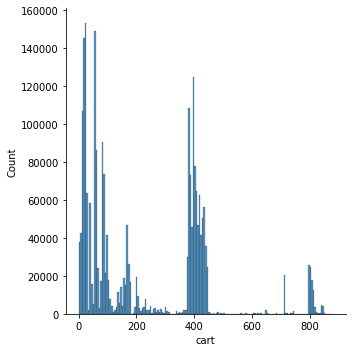

In [9]:
sns.displot(train['cart'])
plt.show()

In [10]:
top_20 = train.groupby(['cart']).agg({'count' : 'count'}).sort_values\
                                (by = 'count' , ascending = False).head(20)
top_20.head()

,count
cart,
57,83722
14,72214
61,70478
398,63190
23,55231


In [11]:
def optimization(df, column_with_quotation): #поправка на популярность
  for i in df.index:
    if df.cart[i] in top_20.index:
      df.loc[(df.index == i), column_with_quotation] = 1
  return df

### Как часто категория была куплена отдельными пользователями?

In [12]:
frequency = train_split.groupby(['user_id','cart']).agg({'count' : 'count'})\
                               .sort_values(by = 'count', ascending = False)
frequency.head()

count
user_id cart       
91      14      125
        16      124
        171     121
        55      117
        409     115

### Рекомендательная система (если вы выбрали этот товар, то вам могут понравиться и следующие: [...])

In [13]:
user_matrix = train_split.pivot_table(index='user_id', columns='cart', \
                                      values='target')
user_matrix = user_matrix.fillna(0)
user_matrix.head(3)

cart,0,1,2,3,4,5,6,7,8,9,...,858,859,863,865,866,867,868,869,873,880
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
def corr_recommendation(category):
  sells = user_matrix[category]
  items_like_this = user_matrix.corrwith(sells)
  recomm = items_like_this.sort_values(ascending=False).head(3)
  list = []
  [list.append(i) for i in recomm.index]
  print(list)

In [15]:
corr_recommendation(6)

[6, 390, 392]


# 3.Выбор ML-модели и обучение

## 3.1 LocalOutlierFactor

In [16]:
X_all_train = train[['user_id', 'cart']]
y_all_train = y_train = train.target

X_train = train_split[['user_id', 'cart']]
y_train = train_split.target

X_test = test_split[['user_id', 'cart']]
y_test= test_split.target

X = sample_data[['user_id', 'cart']]

In [17]:
from sklearn.neighbors import LocalOutlierFactor
clf_1 = LocalOutlierFactor(n_neighbors=2, novelty=True)
clf_1.fit(X_train)
local_output = clf_1.predict(X_test)
local_output = np.clip(local_output, 0, 1)

In [18]:
local_output_final = clf_1.predict(X)
local_output_final = np.clip(local_output_final, 0, 1)

## 3.2 IsolationForest

In [19]:
from sklearn.ensemble import IsolationForest
clf_2 = IsolationForest(random_state=0).fit(X_train)
forest_output = clf_2.predict(X_test)
forest_output = np.clip(forest_output, 0, 1)

In [20]:
forest_output_final = clf_2.predict(X)
forest_output_final = np.clip(forest_output_final, 0, 1)

## 3.3 catboost classifier

In [21]:
import catboost
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=49) 
model.fit(X_train, y_train) 
prediction_test = model.predict(X_test) 

catboost_output_final = model.predict(X)

Learning rate set to 0.5
0:	learn: 0.4859002	total: 174ms	remaining: 8.33s
1:	learn: 0.4165596	total: 277ms	remaining: 6.51s
2:	learn: 0.3881361	total: 382ms	remaining: 5.85s
3:	learn: 0.3752078	total: 490ms	remaining: 5.51s
4:	learn: 0.3683863	total: 598ms	remaining: 5.26s
5:	learn: 0.3649676	total: 694ms	remaining: 4.97s
6:	learn: 0.3616370	total: 792ms	remaining: 4.75s
7:	learn: 0.3588213	total: 890ms	remaining: 4.56s
8:	learn: 0.3573252	total: 986ms	remaining: 4.38s
9:	learn: 0.3550867	total: 1.09s	remaining: 4.24s
10:	learn: 0.3536688	total: 1.2s	remaining: 4.14s
11:	learn: 0.3519539	total: 1.3s	remaining: 4s
12:	learn: 0.3502225	total: 1.41s	remaining: 3.9s
13:	learn: 0.3494454	total: 1.51s	remaining: 3.77s
14:	learn: 0.3487277	total: 1.61s	remaining: 3.66s
15:	learn: 0.3484846	total: 1.71s	remaining: 3.53s
16:	learn: 0.3475607	total: 1.81s	remaining: 3.41s
17:	learn: 0.3469684	total: 1.92s	remaining: 3.31s
18:	learn: 0.3462965	total: 2.04s	remaining: 3.22s
19:	learn: 0.3454378	t

## 3.4. Random Forest

In [22]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score

### Выбор оптимальной глубины

In [23]:
max_depth_values = range(50,101) 
scores_df = pd.DataFrame() 

for depth in max_depth_values:
    clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = depth)
    clf.fit(X_train, y_train)
    train_scores = clf.score(X_train, y_train)
    test_scores = clf.score(X_test, y_test)
    temp_scores = pd.DataFrame({'max_depth': [depth], 'train_score':[train_scores], \
                           'test_score':[test_scores]}) 
    scores_df = scores_df.append(temp_scores)

In [24]:
scores_df.sort_values(by = 'test_score', ascending=False).head()

,max_depth,train_score,test_score
0,96,0.999827,0.854595
0,100,0.999869,0.854551
0,95,0.999818,0.854528
0,94,0.999801,0.854522
0,92,0.999775,0.854520


In [25]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 96)
clf.fit(X_train, y_train)

Decision_score = clf.predict(X_test)

In [26]:
clf_all_train = DecisionTreeClassifier(criterion = 'entropy', max_depth = 96)
clf_all_train.fit(X_all_train, y_all_train)

Decision_score_final = clf_all_train.predict(X)

### Подготовлю DataFrame с результатом работы моделей

In [27]:
sample_data.loc[:, ('user_id', 'cart')] = sample_data[['user_id', 'cart']] \
                                                            .astype('str')

my_submit = pd.DataFrame({'id' : sample_data.user_id, 'cart' : sample_data.cart})
my_submit['id_and_cart'] = my_submit['id'].str.cat(my_submit['cart'], sep =";")

In [28]:
my_submit['Local_score'] = local_output_final.tolist()
my_submit['Forest_score'] = forest_output_final.tolist()
my_submit['catboost_score'] = catboost_output_final.tolist()
my_submit['Decision_score'] = Decision_score_final.tolist()
my_submit['Dec_score_optim'] = Decision_score_final.tolist()
my_submit.head()

,id,cart,id_and_cart,Local_score,Forest_score,catboost_score,Decision_score,Dec_score_optim
0,0,133,0;133,0,0,1,0,0
1,0,5,0;5,1,0,1,0,0
2,0,10,0;10,0,0,1,0,0
3,0,396,0;396,0,0,1,0,0
4,0,14,0;14,0,0,1,1,1


### Оценка работы моделей

In [29]:
pre_train = pd.DataFrame({'user_id' : test_split.user_id,\
                             'cart' : test_split.cart,   \
                           'target' : test_split.target})

pre_train['Local_score'] = local_output.tolist()
pre_train['Forest_score'] = forest_output.tolist()
pre_train['catboost_score'] = prediction_test.tolist()
pre_train['Decision_score'] = Decision_score.tolist()
pre_train['Dec_score_optim'] = Decision_score.tolist()

In [30]:
from sklearn.metrics import roc_auc_score

print(f" Local AUC       = {roc_auc_score(y_test, pre_train.Local_score)}")
print(f" Isol_Forest AUC = {roc_auc_score(y_test, pre_train.Forest_score)}")
print(f" catboost AUC    = {roc_auc_score(y_test, pre_train.catboost_score)}")
print(f" Decision AUC    = {roc_auc_score(y_test, pre_train.Decision_score)}")

 Local AUC       = 0.6869551627278596
 Isol_Forest AUC = 0.6232404307322352
 catboost AUC    = 0.6055291217598544
 Decision AUC    = 0.7332180816683017


### Поправка на популярность товара

In [31]:
optimization(pre_train, 'Dec_score_optim').head()

,user_id,cart,target,Local_score,Forest_score,catboost_score,Decision_score,Dec_score_optim
2576008,18161,23,0,1,0,1,1,1
2576009,18161,17,1,1,0,1,1,1
2576010,18161,14,1,1,0,1,1,1
2576011,18161,5,0,0,0,1,0,0
2576012,18161,445,1,0,0,0,1,1


In [32]:
print(f" Decision_with_optim AUC = {roc_auc_score(y_test, pre_train.Dec_score_optim)}")

 Decision_with_optim AUC = 0.7183783881099465


### Оптимизация финального варианта сабмита

In [33]:
optimization(my_submit,'Dec_score_optim').head()

,id,cart,id_and_cart,Local_score,Forest_score,catboost_score,Decision_score,Dec_score_optim
0,0,133,0;133,0,0,1,0,0
1,0,5,0;5,1,0,1,0,0
2,0,10,0;10,0,0,1,0,0
3,0,396,0;396,0,0,1,0,0
4,0,14,0;14,0,0,1,1,1


# 4.Из DataFrame в csv

### Результат работы Decision tree

In [34]:
submission_with_Decision = pd.DataFrame({'id': my_submit.id_and_cart, 'target': my_submit['Decision_score']})
submission_with_Decision.to_csv('/kaggle/working/submission_with_Decision.csv', index=False)

### Результат работы Decision tree с поправкой на популярность товаров

In [35]:
submission_Decision_optim = pd.DataFrame({'id': my_submit.id_and_cart, 'target': my_submit['Dec_score_optim']})
submission_Decision_optim.to_csv('/kaggle/working/submission_Decision_optim.csv', index=False)